In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from src.renderer import Renderer
from src.data.masked_datamodule import MaskedDataModule
from src.config import get_parser

In [34]:
import argparse

from distutils.util import strtobool

def get_parser():
    parser = argparse.ArgumentParser()
    
    # General
    parser.add_argument('--data_dir', help='Tensor storage',default='./data/')

    # Renderer    
    parser.add_argument('--viewpoint_distance', type=float, default=2.0, 
                        help='Distance from camera to the object')
    parser.add_argument('--viewpoint_elevation', type=float, default=0.0, 
                        help='Angle of elevation in degrees')
    parser.add_argument('--viewpoint_azimuth', type=float, default=0.0, 
                        help='No rotation so the camera is positioned on the +Z axis')
    parser.add_argument('--lights_location', nargs='+', type=float, 
                        default=[0.0, -1.0, 3.0],
                        help="Examples: -lights_location 0.0, -1.0, 3.0")

    parser.add_argument('--raster_image_size', type=int, default=128, 
                        help='Rasterizer image size')
    parser.add_argument('--raster_radius', type=float, default=0.01, 
                        help='Points radius')
    parser.add_argument('--raster_points_per_pixel', type=int, default=4)
    parser.add_argument('--raster_patch_size', type=int, default=256)
    parser.add_argument('--raster_max_brightness', type=float, default=0.7, 
                        help='Maximum brightness of pixel, [0-1]')

    # Discriminator
    parser.add_argument('--D_num_outcomes', help='No of discriminator outcomes', 
                        default=32)    
    parser.add_argument('--D_filters', nargs='+', type=int, 
                        default=[3, 32, 64],
                        help="Examples: -D_filters 3 32 64")
    parser.add_argument('--D_act_name', 
                        help='Discriminator activation name Swish or LeakyReLU',
                        default='Swish')
    parser.add_argument('--D_use_adaptive_reparam', dest='D_use_adaptive_reparam', 
                        default=True, type=lambda x: bool(strtobool(x)))
    parser.add_argument('--D_use_spectral_norm', dest='D_use_spectral_norm', 
                        default=False, type=lambda x: bool(strtobool(x)))
    
    # Stylist
    parser.add_argument('--backbone', default='vgg11')
    
    # Generator
    parser.add_argument('--dlatent_size', type=int, default=128)
    parser.add_argument('--in_channel', type=int, default=6) # 3 just points, 6 normals too
    parser.add_argument('--out_channel',type=int,help='kernel size',default=32)

    parser.add_argument('--blueprint', default='blueprint127.npz')
    parser.add_argument('--G_noise_amp',type=float, help='Generator noise scale.', default=0.003)
    parser.add_argument('--G_use_adaptive_reparam', dest='G_use_adaptive_reparam', 
                        default=True, type=lambda x: bool(strtobool(x)))
    
    #networks hyper parameters:
    parser.add_argument('--nfc', type=int, default=32)
    parser.add_argument('--min_nfc', type=int, default=32)
    parser.add_argument('--ker_size',type=int,help='kernel size',default=3)
    parser.add_argument('--num_layer',type=int,help='number of layers',default=5)
    parser.add_argument('--stride',help='stride',default=1)
    parser.add_argument('--padd_size',type=int,help='net pad size',default=1)#math.floor(opt.ker_size/2)
    
    #parser.add_argument('--mode', help='task to be done', default='train')
    #workspace:
    parser.add_argument('--not_cuda', action='store_true', help='disables cuda', default=0)
    
    #load, input, save configurations:
    parser.add_argument('--netG', default='', help="path to netG (to continue training)")
    parser.add_argument('--netD', default='', help="path to netD (to continue training)")
    parser.add_argument('--manualSeed', type=int, help='manual seed')
    parser.add_argument('--nc_z',type=int,help='noise # channels',default=3)
    parser.add_argument('--nc_im',type=int,help='image # channels',default=3)
    parser.add_argument('--out',help='output folder',default='Output')
        
    #pyramid parameters:
    parser.add_argument('--scale_factor',type=float,help='pyramid scale factor',default=0.75)#pow(0.5,1/6))
    parser.add_argument('--noise_amp',type=float,help='addative noise cont weight',default=0.1)
    parser.add_argument('--min_size',type=int,help='image minimal size at the coarser scale',default=25)
    parser.add_argument('--max_size', type=int,help='image minimal size at the coarser scale', default=250)

    #optimization hyper parameters:
    parser.add_argument('--niter', type=int, default=2000, help='number of epochs to train per scale')
    parser.add_argument('--gamma',type=float,help='scheduler gamma',default=0.1)
    parser.add_argument('--lr_g', type=float, default=0.0005, help='learning rate, default=0.0005')
    parser.add_argument('--lr_d', type=float, default=0.0005, help='learning rate, default=0.0005')
    parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
    parser.add_argument('--Gsteps',type=int, help='Generator inner steps',default=3)
    parser.add_argument('--Dsteps',type=int, help='Discriminator inner steps',default=3)
    parser.add_argument('--lambda_grad',type=float, help='gradient penelty weight',default=0.1)
    parser.add_argument('--alpha',type=float, help='reconstruction loss weight',default=10)

    # data module
    parser.add_argument('--data_blueprint', help='Blueprint file', default='./data/blueprint127.npz')
    parser.add_argument('--data_image_dir', help='Images directory', 
                        default='/home/bobi/Desktop/db/ffhq-dataset/images1024x1024')
    parser.add_argument('--data_mask_dir', help='Image masks directory', 
                        default='/home/bobi/Desktop/face-parsing.PyTorch/res/masks')
    parser.add_argument('--data_image_size', help='Original image size', type=int, default=1024)
    parser.add_argument('--data_mask_size', help='Mask size', type=int, default=512)
    parser.add_argument('--data_image_resized', help='Image resized', type=int, default=256)
    parser.add_argument('--data_patch_size', help='Patch size', type=int, default=256)
    parser.add_argument('--data_style_img', help='Style image size', type=int, default=192)

    parser.add_argument('--batch_size', type=int, default=4)
    parser.add_argument('--num_workers', type=int, default=4)
    

    return parser

config = get_parser().parse_args(args=[])

# Set the cuda device
device = torch.device("cuda:0")

# renderer = Renderer(config).to(device)
# renderer

In [35]:
opt = config
loaded = torch.load(os.path.join(opt.data_dir, 
                'trimap_{}.pth'.format(opt.raster_patch_size)))
for key in loaded.keys():
    print(key, loaded[key].shape, loaded[key].dtype)

vert_tri_indices torch.Size([65536, 6]) torch.int64
vert_tri_weights torch.Size([1, 65536, 6, 1]) torch.float32
faces torch.Size([1, 130050, 3]) torch.int64


In [36]:
import os
import torch 

from pytorch3d.structures import Pointclouds
import pytorch3d.transforms as T3

from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    PointLights,
    PointsRasterizer,
    PointsRasterizationSettings,
)

from src.ShadingPointsRenderer import (
    ShadingCompositor,
    ShadingPointsRenderer,
)
from src.util import make_faces

def vertex_tris(faces):
    res = []
    for vid in range(faces.max()+1):
        vertex_faces = []
        for fid, face in enumerate(faces):
            if vid in face:
                vertex_faces.append(fid)
        res.append(vertex_faces)
    return res

def vertex_tri_maps(faces):
    vts = vertex_tris(faces)
    r, c = len(vts), max([len(x) for  x in vts])
    vert_tri_indices = torch.zeros(r, c, dtype=torch.long)
    vert_tri_weights = torch.zeros(r, c)    
    for r, tris in enumerate(vts):
        weight = 1. / len(tris)
        for c, tri_id in enumerate(tris):
            vert_tri_indices[r, c] = tri_id
            vert_tri_weights[r, c] = weight
    return vert_tri_indices, vert_tri_weights.unsqueeze(dim=-1)[None]

def get_face_normals(vrt, faces):    
    v1 = vrt.index_select(1,faces[:, 1]) - vrt.index_select(1, faces[:, 0])
    v2 = vrt.index_select(1,faces[:, 2]) - vrt.index_select(1, faces[:, 0])
    face_normals = F.normalize(v1.cross(v2), p=2, dim=-1)  # [F, 3]
    return face_normals

def get_vertex_normals(face_normals, vert_tri_indices, vert_tri_weights):
    bs = face_normals.size(0)
    r, c = vert_tri_indices.shape
    fn_group = face_normals.index_select(1, 
        vert_tri_indices.flatten()).reshape(bs, r, c, 3)
    weighted_fn_group = fn_group * vert_tri_weights    
    vertex_normals = weighted_fn_group.sum(dim=-2)
    return F.normalize(vertex_normals, p=2, dim=-1)

class Renderer(torch.nn.Module):
    def __init__(self, opt):    
        super(Renderer, self).__init__()
        self.opt = opt
        self.max_brightness = opt.raster_max_brightness
        # opt.raster_patch_size
        #faces = make_faces(opt.raster_patch_size, opt.raster_patch_size)
        #vert_tri_indices, vert_tri_weights = vertex_tri_maps(faces)     
        trimap =  torch.load(os.path.join(opt.data_dir, 
            'trimap_{}.pth'.format(opt.raster_patch_size)))
        
        self.register_buffer('faces',  trimap['faces'][0])
        self.register_buffer('vert_tri_indices', trimap['vert_tri_indices'])
        self.register_buffer('vert_tri_weights', trimap['vert_tri_weights'])
    
    def to(self, device):
        new_self = super(Renderer, self).to(device)
        
        R, T = look_at_view_transform(
            self.opt.viewpoint_distance, 
            self.opt.viewpoint_elevation, 
            self.opt.viewpoint_azimuth, 
            device=device)
        cameras = FoVPerspectiveCameras(
            device=device, R=R, T=T)
        raster_settings = PointsRasterizationSettings(
            image_size= self.opt.raster_image_size, 
            radius = self.opt.raster_radius,
            points_per_pixel = self.opt.raster_points_per_pixel,
        )
        rasterizer = PointsRasterizer(
            cameras= cameras, 
            raster_settings=raster_settings
        )
        lights = PointLights(device=device, 
                             location=[self.opt.lights_location])
        compositor = ShadingCompositor(
            device=device, 
            cameras=cameras,
            lights=lights
        )        
        new_self.renderer = ShadingPointsRenderer(
            rasterizer=rasterizer,
            compositor=compositor,
        ) 
        return new_self
    
    def __call__(self, points, normals=None):
        # (b, 3, w, h)
        bs = points.size(0)
        points = points.reshape(bs, 3, -1).permute(0, 2, 1)
        rgb = torch.ones((bs, points.size(1), 3), 
                         device=points.device) * self.max_brightness
        if normals is not None:
            normals = normals.reshape(bs, 3, -1).permute(0, 2, 1)
            point_cloud = Pointclouds(points=points, 
                          normals=normals,
                          features=rgb)
        else:
            face_normals = get_face_normals(points, self.faces)
            normals = get_vertex_normals(face_normals,
                self.vert_tri_indices, self.vert_tri_weights)
            point_cloud = Pointclouds(points=points, 
                          normals=normals,
                          features=rgb)      
        #print(points.shape, normals.shape, rgb.shape)
#         T = T3.Translate(-points.mean(dim=0)[None]).to(points.device)
#         pt_points = T.transform_points(pt_points)
#         pt_normals = T.transform_normals(pt_normals)

#         point_cloud = Pointclouds(points=points, 
#                           normals=normals,
#                           features=rgb)
        return self.renderer(point_cloud)
    
    
config = get_parser().parse_args(args=[])

# Set the cuda device
device = torch.device("cuda:0")

renderer = Renderer(config).to(device)
renderer

Renderer(
  (renderer): ShadingPointsRenderer(
    (rasterizer): PointsRasterizer(
      (cameras): FoVPerspectiveCameras()
    )
    (compositor): ShadingCompositor(
      (lights): PointLights()
      (materials): Materials()
      (cameras): FoVPerspectiveCameras()
    )
  )
)

In [37]:
blueprint = np.load(os.path.join(config.data_dir, config.blueprint))
points = torch.tensor(blueprint['points'])#[0]
normals = torch.tensor(blueprint['normals'])#[0]
points.shape, normals.shape


(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

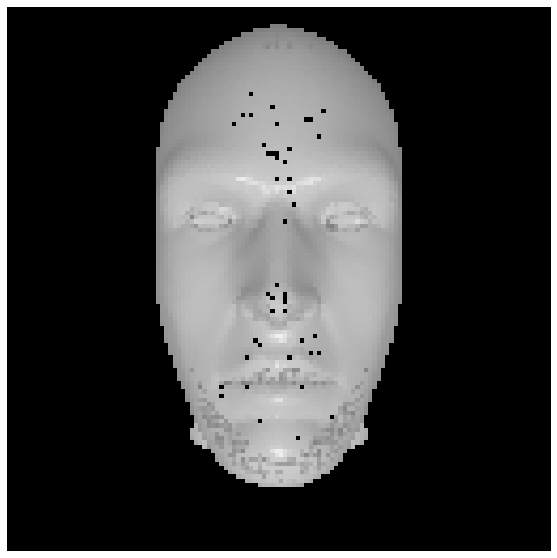

In [38]:

images = renderer(points.to(device), normals.to(device))

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

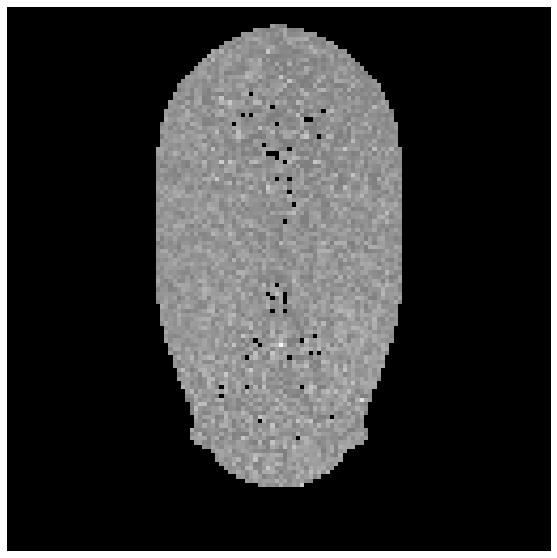

In [39]:
vrt.shape, faces.shape   
mesh = Meshes(verts=vrt, faces=faces)
mesh_normals = mesh.verts_normals_packed()#.shape


images = renderer(points.to(device), mesh_normals)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

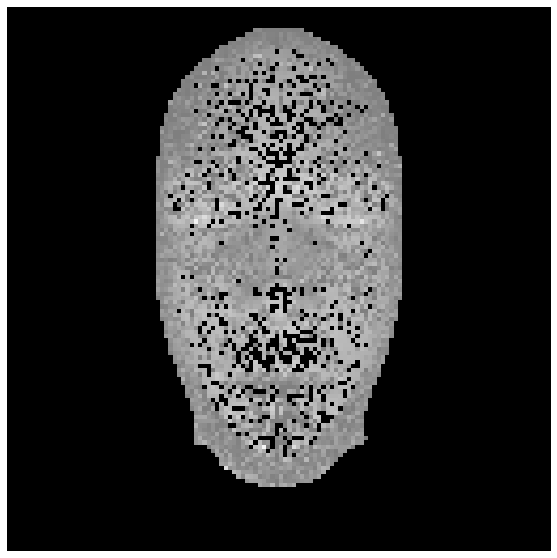

In [28]:

images = renderer(points.to(device))

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

In [9]:
op = config
bs = points.size(0)
vrt = points.reshape(bs, 3, -1).permute(0, 2, 1).to(device)
trimap =  torch.load(os.path.join(opt.data_dir, 
            'trimap_{}.pth'.format(opt.raster_patch_size)))
faces =  trimap['faces'].to(device) 
vrt.shape, faces.shape    

(torch.Size([1, 65536, 3]), torch.Size([1, 130050, 3]))

In [10]:
def get_face_normals(vrt, faces):    
    v1 = vrt.index_select(1,faces[:, 1]) - vrt.index_select(1, faces[:, 0])
    v2 = vrt.index_select(1,faces[:, 2]) - vrt.index_select(1, faces[:, 0])
    face_normals = F.normalize(v1.cross(v2), p=2, dim=-1)  # [F, 3]
    return face_normals

face_normals = get_face_normals(vrt, faces[0])

In [12]:
bs = points.size(0)
points = points.reshape(bs, 3, -1).permute(0, 2, 1)
rgb = torch.ones((bs, points.size(1), 3), 
                 device=points.device) #* self.max_brightness
point_cloud = Pointclouds(points=points, 
              features=rgb)
point_cloud

In [13]:
from pytorch3d.structures import Meshes

#mesh = Meshes()

torch.Size([65536, 3])